# Explore LCA

Importing the LCA data from [Heller et al. (2018)](https://iopscience.iop.org/article/10.1088/1748-9326/aab0ac) and seeing if we can lump our more specific food codes into the more general codes linked to GHG emissions and cumulative energy demand.

Work in progress!

## Housekeeping

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.getcwd()

'/content'

In [ ]:
os.chdir('/content/drive/MyDrive/ds1_nhanes/')
os.getcwd()

'/content/drive/MyDrive/ds1_nhanes'

In [ ]:
# Don't run - local use only

# import os
# from pathlib import Path
# os.chdir(Path(os.getcwd()).parent)
# print(os.getcwd())

In [ ]:
import pandas as pd
import numpy as np

## Load Datasets

Loading them all here to be clear what we're working with

In [ ]:
# LCA data from dataFIELD database, Heller et al 2018
lca = pd.read_csv('data/raw/dataFIELDv1.0_FCID_linkages.csv', skiprows=2)
print(lca.columns)

# Reduce to relevant columns
lca = lca[['FCID_Code', 'FCID_Desc', 'MJ / kg', 'CO2 eq / kg']]
print(lca.info())

Index(['FCID_Code', 'FCID_Desc', 'Weight_Basis_ as defined by FCID',
       'Comments (from FCID)', 'N_Cases', 'MJ / kg', 'CO2 eq / kg',
       'weight Conversion Factor', 'conversion factor source',
       ' or processor gate (=2)?', 'Unnamed: 10', 'Unnamed: 11',
       '# of datapoints', 'N-average', 'Std. Dev', 'Unnamed: 15',
       '# of datapoints.1', 'N-average.1', 'Std. Dev.1', 'Unnamed: 19',
       'Unnamed: 20', 'Unnamed: 21', 'basis', 'n', 'proxy group mean',
       'SD (group or indiv food)', 'scaled SD (group SD*food mean/group mean)',
       'basis.1', 'n.1', 'proxy group mean.1', 'SD (group or indiv food).1',
       'scaled SD (group SD*food mean/group mean).1'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   FCID_Code    354 non-null    float64
 1   FCID_Desc    354 non-null    object 
 2   MJ / kg      35

In [ ]:
# Dietary recall data, NHANES 2021-2023
dr1 = pd.read_sas('data/raw/nhanes_2021_2023/DR1IFF_L.xpt')

# Print column names
print(dr1.columns)

# Select relevant columns - IDs, weights, food codes, and grams
dr1 = dr1[['SEQN', 'WTDRD1', 'WTDR2D', 'DR1IFDCD', 'DR1IGRMS']]
print(dr1.info())

Index(['SEQN', 'WTDRD1', 'WTDR2D', 'DR1ILINE', 'DR1DRSTZ', 'DR1EXMER', 'DRABF',
       'DRDINT', 'DR1DBIH', 'DR1DAY', 'DR1LANG', 'DR1CCMNM', 'DR1CCMTX',
       'DR1_020', 'DR1_030Z', 'DR1FS', 'DR1_040Z', 'DR1IFDCD', 'DR1IGRMS',
       'DR1IKCAL', 'DR1IPROT', 'DR1ICARB', 'DR1ISUGR', 'DR1IFIBE', 'DR1ITFAT',
       'DR1ISFAT', 'DR1IMFAT', 'DR1IPFAT', 'DR1ICHOL', 'DR1IATOC', 'DR1IATOA',
       'DR1IRET', 'DR1IVARA', 'DR1IACAR', 'DR1IBCAR', 'DR1ICRYP', 'DR1ILYCO',
       'DR1ILZ', 'DR1IVB1', 'DR1IVB2', 'DR1INIAC', 'DR1IVB6', 'DR1IFOLA',
       'DR1IFA', 'DR1IFF', 'DR1IFDFE', 'DR1ICHL', 'DR1IVB12', 'DR1IB12A',
       'DR1IVC', 'DR1IVD', 'DR1IVK', 'DR1ICALC', 'DR1IPHOS', 'DR1IMAGN',
       'DR1IIRON', 'DR1IZINC', 'DR1ICOPP', 'DR1ISODI', 'DR1IPOTA', 'DR1ISELE',
       'DR1ICAFF', 'DR1ITHEO', 'DR1IALCO', 'DR1IMOIS', 'DR1IS040', 'DR1IS060',
       'DR1IS080', 'DR1IS100', 'DR1IS120', 'DR1IS140', 'DR1IS160', 'DR1IS180',
       'DR1IM161', 'DR1IM181', 'DR1IM201', 'DR1IM221', 'DR1IP182', 'DR1IP183',

In [ ]:
# Recipe data (links WWEIA codes from NHANES with ingredients from FCID in dataFIELD)
recipes = pd.read_csv('data/miscellany/Recipes_WWEIA_FCID_0510.csv')
print(recipes.columns)
# Food_Code is FNDDS (NHANES)
# FCID_Code links to dataFIELD LCA data
# Commodity_Weight is percentage of that recipe made up of the commodity

# Reduce to relevant columns
recipes = recipes[['Food_Code', 'FCID_Code', 'Commodity_Weight']]
print(recipes.info())

Index(['Food_Code', 'Mod_Code', 'Ingredient_Num', 'FCID_Code', 'Cooked_Status',
       'Food_Form', 'Cooking_Method', 'Commodity_Weight', 'CSFII_9498_IND',
       'WWEIA_9904_IND', 'WWEIA_0510_IND'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129863 entries, 0 to 129862
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Food_Code         129863 non-null  int64  
 1   FCID_Code         129823 non-null  float64
 2   Commodity_Weight  129823 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 3.0 MB
None


## Join DR1 with recipes

The goal here is that instead of having FNDDS codes associated with each record of consumption, we will have a much larger dataset that is broken down into individual FCID commodities. Then we can tie those to the GHG and CED data.

In [ ]:
# Join DR1 with recipes
dr1_recipes = pd.merge(dr1, recipes, left_on='DR1IFDCD', right_on='Food_Code', how='left')
dr1_recipes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 791064 entries, 0 to 791063
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   SEQN              791064 non-null  float64
 1   WTDRD1            791064 non-null  float64
 2   WTDR2D            791064 non-null  float64
 3   DR1IFDCD          791064 non-null  float64
 4   DR1IGRMS          790735 non-null  float64
 5   Food_Code         762183 non-null  float64
 6   FCID_Code         760068 non-null  float64
 7   Commodity_Weight  760068 non-null  float64
dtypes: float64(8)
memory usage: 48.3 MB


In [ ]:
dr1_recipes.head()

,SEQN,WTDRD1,WTDR2D,DR1IFDCD,DR1IGRMS,Food_Code,FCID_Code,Commodity_Weight
0,130378.0,61366.555827,70554.222162,94000100.0,120.0,94000100.0,8.601100e+09,100.00
1,130378.0,61366.555827,70554.222162,94000100.0,120.0,94000100.0,8.601100e+09,100.00
2,130378.0,61366.555827,70554.222162,92101000.0,300.0,92101000.0,8.602000e+09,100.00
3,130378.0,61366.555827,70554.222162,92101000.0,300.0,92101000.0,9.500115e+09,2.19
4,130378.0,61366.555827,70554.222162,94000100.0,240.0,94000100.0,8.601100e+09,100.00


## Join dr1_recipes with LCA data

This should not add rows, but add columns with GHGs and CED for each ingredient (FDIC code)

In [ ]:
dr1_recipes_lca = pd.merge(
    dr1_recipes,
    lca,
    left_on='FCID_Code',
    right_on='FCID_Code',
    how='left'
)
dr1_recipes_lca.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20752488 entries, 0 to 20752487
Data columns (total 11 columns):
 #   Column            Dtype  
---  ------            -----  
 0   SEQN              float64
 1   WTDRD1            float64
 2   WTDR2D            float64
 3   DR1IFDCD          float64
 4   DR1IGRMS          float64
 5   Food_Code         float64
 6   FCID_Code         float64
 7   Commodity_Weight  float64
 8   FCID_Desc         object 
 9   MJ / kg           float64
 10  CO2 eq / kg       float64
dtypes: float64(10), object(1)
memory usage: 1.7+ GB


In [ ]:
dr1_recipes_lca.head()

,SEQN,WTDRD1,WTDR2D,DR1IFDCD,DR1IGRMS,Food_Code,FCID_Code,Commodity_Weight,FCID_Desc,MJ / kg,CO2 eq / kg
0,130378.0,61366.555827,70554.222162,94000100.0,120.0,94000100.0,8.601100e+09,100.00,"Water, direct, tap",0.007,0.000
1,130378.0,61366.555827,70554.222162,94000100.0,120.0,94000100.0,8.601100e+09,100.00,"Water, direct, tap",0.007,0.000
2,130378.0,61366.555827,70554.222162,92101000.0,300.0,92101000.0,8.602000e+09,100.00,"Water, indirect, all sources",0.000,0.000
3,130378.0,61366.555827,70554.222162,92101000.0,300.0,92101000.0,9.500115e+09,2.19,"Coffee, roasted bean",64.581,6.279
4,130378.0,61366.555827,70554.222162,94000100.0,240.0,94000100.0,8.601100e+09,100.00,"Water, direct, tap",0.007,0.000


This now has a bajillion rows because each line is an ingredient in a recipe in a food that each person may have had a bunch of over 24 hours.

## Explore CO2 and CED impacts per respondent

First calculate the amount of CO2 and CED per ingredient/commodity

In [ ]:
dr1_recipes_lca.head()

,SEQN,WTDRD1,WTDR2D,DR1IFDCD,DR1IGRMS,Food_Code,FCID_Code,Commodity_Weight,FCID_Desc,MJ / kg,CO2 eq / kg
0,130378.0,61366.555827,70554.222162,94000100.0,120.0,94000100.0,8.601100e+09,100.00,"Water, direct, tap",0.007,0.000
1,130378.0,61366.555827,70554.222162,94000100.0,120.0,94000100.0,8.601100e+09,100.00,"Water, direct, tap",0.007,0.000
2,130378.0,61366.555827,70554.222162,92101000.0,300.0,92101000.0,8.602000e+09,100.00,"Water, indirect, all sources",0.000,0.000
3,130378.0,61366.555827,70554.222162,92101000.0,300.0,92101000.0,9.500115e+09,2.19,"Coffee, roasted bean",64.581,6.279
4,130378.0,61366.555827,70554.222162,94000100.0,240.0,94000100.0,8.601100e+09,100.00,"Water, direct, tap",0.007,0.000


In [ ]:
# Multiply DR1IGRMS by Commodity_Weight / 100 to get grams consumed
# Then divide by 1000 to get kg consumed
# Then multiply by CO2 eq / kg to get CO2 eq in kg

# Get kg of each line item
dr1_recipes_lca['kg'] = (dr1_recipes_lca['DR1IGRMS'] * (dr1_recipes_lca['Commodity_Weight'] / 100)) / 1000

# Get kg co2 and ced
dr1_recipes_lca['co2_eq'] = dr1_recipes_lca['kg'] * dr1_recipes_lca['CO2 eq / kg']
dr1_recipes_lca['ced'] = dr1_recipes_lca['kg'] * dr1_recipes_lca['MJ / kg']

dr1_recipes_lca.head(10)

,SEQN,WTDRD1,WTDR2D,DR1IFDCD,DR1IGRMS,Food_Code,FCID_Code,Commodity_Weight,FCID_Desc,MJ / kg,CO2 eq / kg,kg,co2_eq,ced
0,130378.0,61366.555827,70554.222162,94000100.0,120.0,94000100.0,8.601100e+09,100.000,"Water, direct, tap",0.007,0.000,0.120000,0.000000,0.000840
1,130378.0,61366.555827,70554.222162,94000100.0,120.0,94000100.0,8.601100e+09,100.000,"Water, direct, tap",0.007,0.000,0.120000,0.000000,0.000840
2,130378.0,61366.555827,70554.222162,92101000.0,300.0,92101000.0,8.602000e+09,100.000,"Water, indirect, all sources",0.000,0.000,0.300000,0.000000,0.000000
3,130378.0,61366.555827,70554.222162,92101000.0,300.0,92101000.0,9.500115e+09,2.190,"Coffee, roasted bean",64.581,6.279,0.006570,0.041253,0.424297
4,130378.0,61366.555827,70554.222162,94000100.0,240.0,94000100.0,8.601100e+09,100.000,"Water, direct, tap",0.007,0.000,0.240000,0.000000,0.001680
5,130378.0,61366.555827,70554.222162,83102000.0,4.9,83102000.0,6.003500e+08,42.292,"Soybean, oil",7.616,0.807,0.002072,0.001672,0.015783
6,130378.0,61366.555827,70554.222162,83102000.0,4.9,83102000.0,9.500390e+09,17.008,Vinegar,7.986,1.319,0.000833,0.001099,0.006655
7,130378.0,61366.555827,70554.222162,83102000.0,4.9,83102000.0,1.500125e+09,4.988,"Corn, field, oil",15.166,1.199,0.000244,0.000293,0.003707
8,130378.0,61366.555827,70554.222162,83102000.0,4.9,83102000.0,2.003128e+09,3.742,"Cottonseed, oil",24.800,2.140,0.000183,0.000392,0.004547
9,130378.0,61366.555827,70554.222162,83102000.0,4.9,83102000.0,2.001319e+09,2.098,"Rapeseed, oil",13.328,2.275,0.000103,0.000234,0.001370


In [ ]:
# Try grouping by SEQN to get each person's CO2 for the day
impact_df = dr1_recipes_lca.groupby('SEQN').agg(
    SEQN=('SEQN', 'first'),
    co2_eq=('co2_eq', 'sum'),
    ced=('ced', 'sum'),
    WTDRD1=('WTDRD1', 'first')
)
print(impact_df.info())
impact_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 6751 entries, 130378.0 to 142310.0
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SEQN    6751 non-null   float64
 1   co2_eq  6751 non-null   float64
 2   ced     6751 non-null   float64
 3   WTDRD1  6751 non-null   float64
dtypes: float64(4)
memory usage: 263.7 KB
None


,SEQN,co2_eq,ced,WTDRD1
SEQN,,,,
130378.0,130378.0,1.537571,9.828364,61366.555827
130379.0,130379.0,12.136315,19.136451,34638.056480
130380.0,130380.0,3.145898,15.927339,84728.261560
130381.0,130381.0,2.316317,13.423874,61737.133446
130382.0,130382.0,0.177710,2.190847,75846.746917


Check summary stats of co2_eq and ced for each SEQN:

In [ ]:
impact_df.describe()

,SEQN,co2_eq,ced,WTDRD1
count,6751.000000,6751.000000,6751.000000,6751.000000
mean,136324.700933,2.899967,17.711668,48411.105727
std,3451.800447,6.500241,42.709970,39255.651594
min,130378.000000,0.000000,0.000000,5708.632624
25%,133291.500000,0.594827,3.951995,23489.222704
50%,136380.000000,1.301853,7.674943,36386.856358
75%,139295.500000,2.787141,15.734864,59518.005782
max,142310.000000,202.782004,1111.896593,408505.813642


kg CO2 equivalent per person ranges from 0 (?) to 202 kg, with a median of 1.3. That's a wild range. CED ranges from 0 to 1111 MJ, median of 7.67. Also wild.

Let's make graphs. Note that the y-axis scale is in the millions because it is just multiplying the survey weights out.

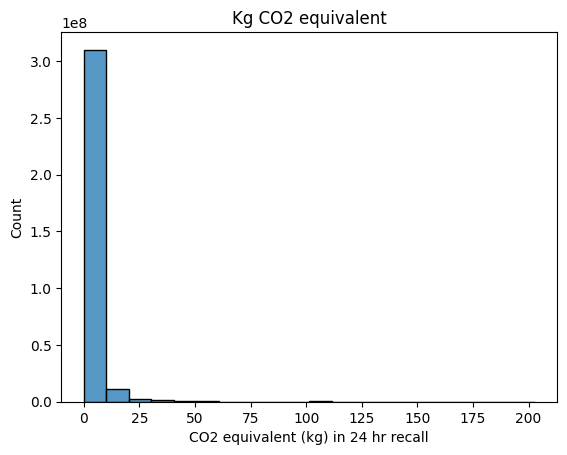

In [ ]:
# Histogram of CO2 equivalent for each person
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.histplot(
    impact_df,
    x='co2_eq',
    bins=20,
    weights='WTDRD1'
)
ax.set_title('Kg CO2 equivalent')
ax.set_xlabel('CO2 equivalent (kg) in 24 hr recall')
plt.show()

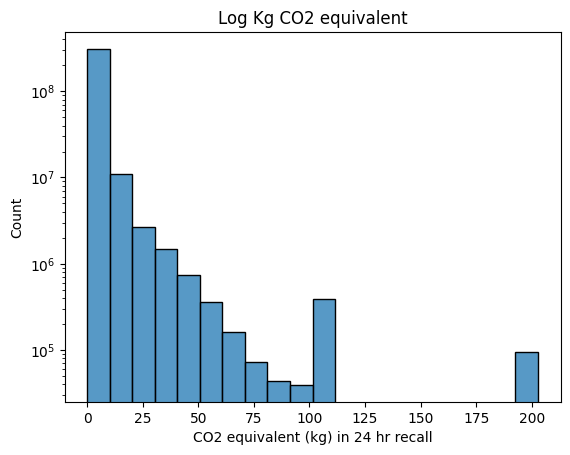

In [ ]:
# Try log transforming
ax = sns.histplot(
    impact_df,
    x='co2_eq',
    bins=20,
    weights='WTDRD1'
)
ax.set_title('Log Kg CO2 equivalent')
ax.set_xlabel('CO2 equivalent (kg) in 24 hr recall')
ax.set_yscale('log')

# Save to png
plt.savefig('outputs/checkin_1/DR1_2021_2023_co2eq_per_seqn.png')

# Also show plot
plt.show()


Curious what's going on with the spikes around 100 and 200

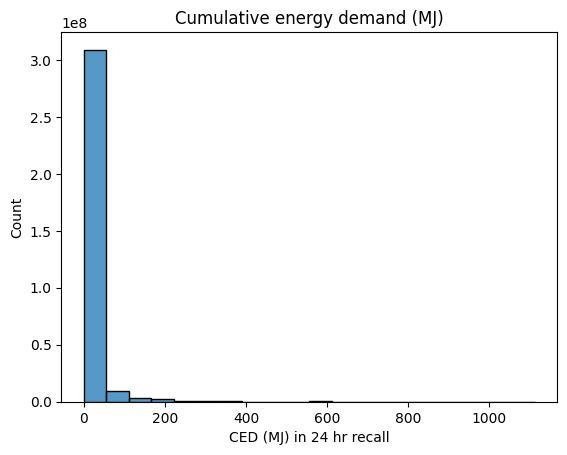

In [ ]:
# Histogram of MJ per person
ax = sns.histplot(
    impact_df,
    x='ced',
    bins=20,
    weights='WTDRD1'
)
ax.set_title('Cumulative energy demand (MJ)')
ax.set_xlabel('CED (MJ) in 24 hr recall')
plt.show()

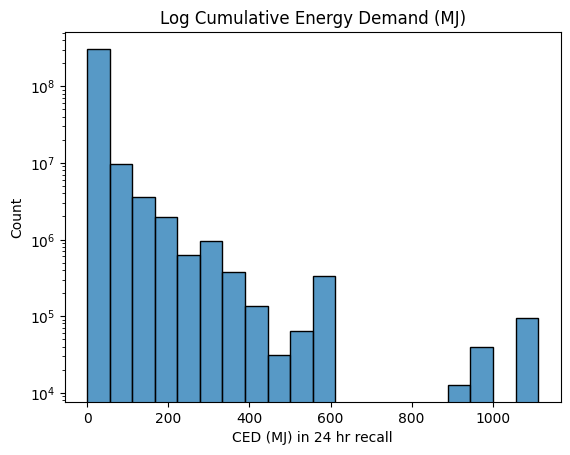

In [ ]:
# Log transform
ax = sns.histplot(
    impact_df,
    x='ced',
    bins=20,
    weights='WTDRD1'
)
ax.set_title('Log Cumulative Energy Demand (MJ)')
ax.set_xlabel('CED (MJ) in 24 hr recall')
ax.set_yscale('log')

# Save to png
plt.savefig('outputs/checkin_1/DR1_2021_2023_ced_per_seqn.png')

plt.show()

Similar spikes around 600 around 1000.

Some issues:

* Not clear why we are getting to 20 million rows when we combine the LCA data to the dr1_recipes data. I would think that shouldn't add rows at all. Need to figure this out.
* Definitely need to explore how much missing data this leaves us with. Not sure what we lost in the left merges.
* Use 2 day data, also combine 2 or more waves